<a href="https://colab.research.google.com/github/breno-gabriel/Intrusion-Detection-/blob/main/Entrega_Aula_Pr%C3%A1tica_4_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

from tqdm.notebook import tqdm

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [ ]:
sns.set_theme()

In [ ]:
RANDOM_SEED = 99
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Download CIC IDS 2017

[Este](https://www.unb.ca/cic/datasets/ids-2017.html) conjunto de dados contém informações sobre fluxos de rede, representando tanto o tráfego benigno quanto ataques populares. Para o ambiente de teste desta coleta de dados, uma rede foi configurada para o atacante e uma rede separada foi configurada para as vítimas, esta última contendo firewalls, roteadores, switches, servidores e estações de trabalho em execução em diferentes versões dos sistemas operacionais Windows e Linux. Para gerar o tráfego benigno, os autores utilizaram um sistema desenvolvido por eles mesmos, que então extraiu o comportamento abstrato de 25 usuários com base em diferentes protocolos de aplicação. Os dados foram coletados ao longo de cinco dias de atividade de rede e foram processados para extrair mais de 80 features do conjunto de dados usando a ferramenta CICFlowMeter8.


In [ ]:
# update gdown version
!pip install --upgrade --no-cache-dir gdown

In [ ]:
# !wget 'http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/MachineLearningCSV.zip' -O CIC_IDS_2017.zip
!gdown '1WtbUHBpANHLMVVHuaFr9-pGUyeW6QhdD' -O CIC_IDS_2017.zip

Downloading...
From (original): https://drive.google.com/uc?id=1WtbUHBpANHLMVVHuaFr9-pGUyeW6QhdD
From (redirected): https://drive.google.com/uc?id=1WtbUHBpANHLMVVHuaFr9-pGUyeW6QhdD&confirm=t&uuid=c20e3109-f40e-46d0-ad26-63ee4519bee7
To: /content/CIC_IDS_2017.zip
100% 235M/235M [00:02<00:00, 102MB/s]


In [ ]:
# !unzip MachineLearningCSV.zip
!unzip CIC_IDS_2017.zip

Archive:  CIC_IDS_2017.zip
replace MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Carregando os dados

In [ ]:
df_list = []
for file in os.listdir('MachineLearningCVE/'):
  df_aux = pd.read_csv(f'MachineLearningCVE/{file}')
  df_list.append(df_aux)
df = pd.concat(df_list, ignore_index=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [ ]:
list(df.columns)[:6]

[' Destination Port',
 ' Flow Duration',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 'Total Length of Fwd Packets',
 ' Total Length of Bwd Packets']

Algumas colunas tem seus nomes iniciados com espaços ou finalizados com espaços. Vamos remover esses espaços não úteis para ajustar o nome das colunas.

In [ ]:
df.columns = df.columns.str.strip()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  

# Limpando os dados

É necessário limpar os dados realizando:
- Descarte de registros duplicados
- Descarte de registros com valores NaN (Not a Number)/ Null / NA (Not Available)
- Evitar registros com valores não finitos. Nesse caso, uma abordagem válida é substituirmos os mesmos pelo maior valor finito presente no dataset.

Registros duplicados

In [ ]:
df[df.duplicated()]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
53,53,210,2,2,64,96,32,32,32.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
54,53,162,2,2,64,158,32,32,32.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
63,53,214,2,2,64,96,32,32,32.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
107,53,163,2,2,64,158,32,32,32.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
171,53,201,2,2,64,96,32,32,32.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830685,137,4,2,0,124,0,62,62,62.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830694,53,184,2,2,84,310,42,42,42.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830696,53,168,2,2,72,194,36,36,36.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830704,53,176,2,2,142,242,71,71,71.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
# Descartando duplicadas
initial_len = df.shape[0]
df = df.drop_duplicates()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartadas {initial_len - df.shape[0]} duplicadas')

Tamanho inicial: 2830743, tamanho final 2522362 | Descartadas 308381 duplicadas


Registros com valores Null/NaN/NA

In [ ]:
df.columns[df.isna().any(axis=0)]

Index(['Flow Bytes/s'], dtype='object')

In [ ]:
df[df.isna().any(axis=1)][['Flow Bytes/s']]

,Flow Bytes/s
6023,NaN
8852,NaN
23054,NaN
30556,NaN
44164,NaN
...,...
2577607,NaN
2578213,NaN
2611794,NaN
2619737,NaN


In [ ]:
# Descartando registros com valores NaN/Null/NA
initial_len = df.shape[0]
df = df.dropna()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartados {initial_len - df.shape[0]} registros com valores NA')

Tamanho inicial: 2522362, tamanho final 2522009 | Descartados 353 registros com valores NA


In [ ]:
df = df.reset_index(drop=True)

Registros com valores não finitos

In [ ]:
df_columns_isfinite = np.isfinite(df.drop(['Label'], axis='columns')).all(axis=0)
df_columns_isfinite[df_columns_isfinite == False]

Flow Bytes/s      False
Flow Packets/s    False
dtype: bool

In [ ]:
df_rows_isfinite = np.isfinite(df.drop(['Label'], axis='columns')).all(axis=1)
inf_indexes = df_rows_isfinite[df_rows_isfinite == False].index
df.iloc[inf_indexes][['Flow Bytes/s', 'Flow Packets/s', 'Flow Duration']]

,Flow Bytes/s,Flow Packets/s,Flow Duration
131,inf,inf,0
354,inf,inf,0
489,inf,inf,0
757,inf,inf,0
2706,inf,inf,0
...,...,...,...
2507126,inf,inf,0
2511105,inf,inf,0
2511877,inf,inf,0
2511898,inf,inf,0


In [ ]:
# Evitando registros com valores não finitos
max_finite_flow_packets_per_sec = df[np.isfinite(df['Flow Packets/s'])]['Flow Packets/s'].max()
max_finite_flow_bytes_per_sec = df[np.isfinite(df['Flow Bytes/s'])]['Flow Bytes/s'].max()

df.loc[df['Flow Packets/s'] == np.inf, 'Flow Packets/s'] = max_finite_flow_packets_per_sec
df.loc[df['Flow Bytes/s'] == np.inf, 'Flow Bytes/s'] = max_finite_flow_bytes_per_sec

# Mini análise exploratória

### Quantidade de instâncias benignas x maliciosas

<Axes: xlabel='Label', ylabel='count'>

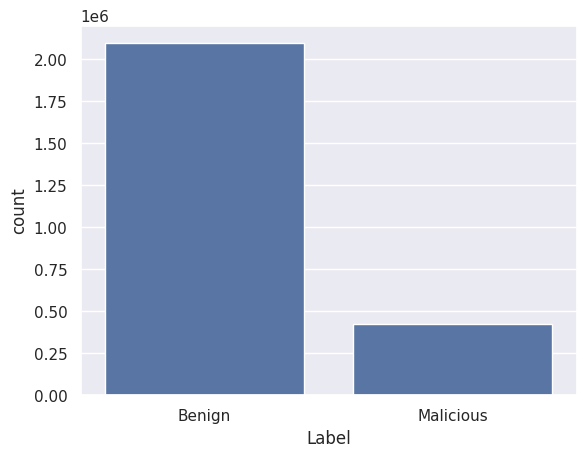

In [ ]:
sns.countplot(data=df['Label'].apply(lambda label: 'Malicious' if label != 'BENIGN' else 'Benign').to_frame(), x='Label')

**Dados não balanceados**. Impactos:
- Dificuldade de treinar modelos supervisionados
- Dificuldade de avaliar resultados com métricas tradicionais como acurácia

### Quantidade de instâncias por tipo de ataque

Abaixo está um descritivo para os ataques do dataset:

**DoS (Denial of Service)**: Esses ataques, como "DoS Hulk", "DoS GoldenEye", "DoS Slowloris", "DoS Slowhttptest" e "DDoS" visam tornar temporariamente uma máquina ou recurso de rede indisponível, sendo diferenciados pelo protocolo e estratégia usados para causar a negação de serviço. No caso do "DDoS", várias máquinas Windows 8.1 foram usadas para enviar solicitações UDP, TCP e HTTP.

**FTP Patator" e "SSH Patator**: Usam o software Patator para adivinhar senhas por força bruta com o uso de listas de palavras.

**Web - Brute Force**: Usa força bruta em uma aplicação com listas de palavras.

**Web - Injeção de SQL**: Esse ataque explora vulnerabilidades em máquinas conectadas publicamente à Internet usando injeção SQL.

**Web - XSS (Cross-Site Scripting)**: Representa injeções de scripts em aplicativos da web, visando a execução de ações maliciosas por outros usuários do aplicativo.

**PortScan**: Realizados com a ferramenta NMap, esses ataques buscam informações sobre os serviços e portas abertas em um alvo.

**Bot**: Esse ataque tem várias possibilidades, como roubo de dados, envio de spam e acesso ao dispositivo. .

**Infiltration**: Baseado na infecção de uma máquina após um usuário abrir um arquivo malicioso.

In [ ]:
df['Label'] = df['Label'].replace({'Web Attack � Brute Force':'Brute Force', 'Web Attack � XSS':'XSS', 'Web Attack � Sql Injection':'Sql Injection'})

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'DoS Hulk'),
  Text(1, 0, 'DDoS'),
  Text(2, 0, 'PortScan'),
  Text(3, 0, 'DoS GoldenEye'),
  Text(4, 0, 'FTP-Patator'),
  Text(5, 0, 'DoS slowloris'),
  Text(6, 0, 'DoS Slowhttptest'),
  Text(7, 0, 'SSH-Patator'),
  Text(8, 0, 'Bot'),
  Text(9, 0, 'Brute Force'),
  Text(10, 0, 'XSS'),
  Text(11, 0, 'Infiltration'),
  Text(12, 0, 'Sql Injection'),
  Text(13, 0, 'Heartbleed')])

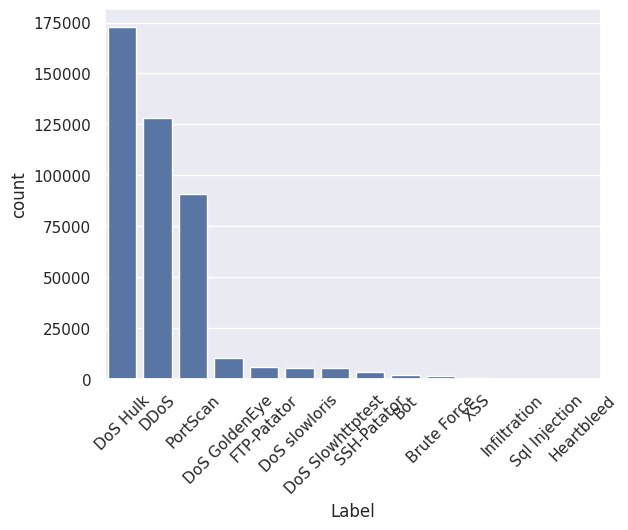

In [ ]:
sns.countplot(data=df.query('Label != "BENIGN"')[['Label']], x='Label', order = df.query('Label != "BENIGN"')['Label'].value_counts().index)
plt.xticks(rotation=45)

Ataques menos representados

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Brute Force'),
  Text(1, 0, 'XSS'),
  Text(2, 0, 'Sql Injection'),
  Text(3, 0, 'Infiltration'),
  Text(4, 0, 'Heartbleed')])

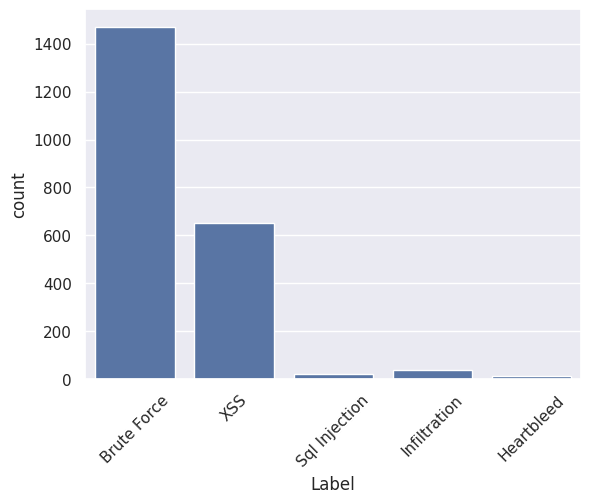

In [ ]:
N_LESS_REPRESENTED_LABELS = 5

sns.countplot(data=df[df['Label'].isin(df.groupby('Label').size().sort_values(ascending=False)[(-1)*N_LESS_REPRESENTED_LABELS:].index)], x='Label')
plt.xticks(rotation=45)

### Estatísticas dos dados

In [ ]:
interesting_cols = ['Flow Duration', 'Flow Bytes/s', 'Total Fwd Packets', 'Average Packet Size', 'SYN Flag Count']
df[interesting_cols].describe()

,Flow Duration,Flow Bytes/s,Total Fwd Packets,Average Packet Size,SYN Flag Count
count,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06
mean,1.658364e+07,2.404467e+06,1.027750e+01,2.123412e+02,4.874487e-02
std,3.522618e+07,5.254864e+07,7.942294e+02,3.454504e+02,2.153342e-01
min,-1.300000e+01,-2.610000e+08,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.080000e+02,1.194510e+02,2.000000e+00,9.000000e+00,0.000000e+00
50%,5.058700e+04,3.722028e+03,2.000000e+00,8.075000e+01,0.000000e+00
75%,5.330376e+06,1.079162e+05,6.000000e+00,1.796923e+02,0.000000e+00
max,1.200000e+08,2.071000e+09,2.197590e+05,3.893333e+03,1.000000e+00


# Dividindo dados nos conjuntos de treino, validação e teste

**Conjunto de treino**

Para a detecção de anomalias, vamos usar somente os dados que representam o tráfego benigno para o conjunto de treino. Dessa forma, os algoritmos de clustering vão ser capazes de identificar padrões e desvios em relação ao comportamento normal (benigno) dos dados.

**Conjuntos de validação e teste**

Porém, devem ser incluídos dados que representam o tráfego maliciosos nos conjuntos de validação e teste. Esses dados maliciosos no conjunto de validação são importantes para que possamos definir um *threshold* para que seja possível detectar anomalias. Além disso, os dados maliciosos também precisam ser incluídos no conjunto de teste para que possamos avaliar o desempenho do nosso modelo.

In [ ]:
df_train = df.query('Label == "BENIGN"').sample(frac=0.6, random_state=RANDOM_SEED)
df_val_test = df.drop(df_train.index)

df_train = df_train.reset_index(drop=True)
df_val_test = df_val_test.reset_index(drop=True)

X_train = df_train.drop('Label', axis='columns')

In [ ]:
X_val, X_test, classes_val, classes_test = train_test_split(df_val_test.drop('Label', axis='columns'), df_val_test['Label'], test_size=0.65, stratify=df_val_test['Label'], random_state=RANDOM_SEED)

X_val, X_test = X_val.reset_index(drop=True), X_test.reset_index(drop=True)
classes_val, classes_test =  classes_val.reset_index(drop=True), classes_test.reset_index(drop=True)

y_val, y_test = classes_val.apply(lambda c: 0 if c == 'BENIGN' else 1), classes_test.apply(lambda c: 0 if c == 'BENIGN' else 1)

In [ ]:
del df_train, df_val_test

# Analisando correlação entre features

**Por que remover features?**

Vamos descartar features com alta correlação evitando passar informações redundantes ao modelo. Dessa forma, conseguiremos obter um modelo mais simples e com menor custo computacional.

In [ ]:
def get_highly_correlated_features(correlation_matrix, threshold):
  correlated_pairs = []
  for i in range(len(correlation_matrix.columns)):
    for j in range(i):
      if abs(correlation_matrix.iloc[i, j]) > threshold:
        pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
        coefficient = correlation_matrix.iloc[i, j]
        correlated_pairs.append((pair, coefficient))
  return sorted(correlated_pairs, key= lambda pair: pair[1], reverse=True)


In [ ]:
corr_matrix = X_train.corr().abs()
correlation_list = get_highly_correlated_features(corr_matrix, 0.95)

In [ ]:
correlation_list[:10]

[(('SYN Flag Count', 'Fwd PSH Flags'), 1.0),
 (('CWE Flag Count', 'Fwd URG Flags'), 1.0),
 (('Avg Fwd Segment Size', 'Fwd Packet Length Mean'), 1.0),
 (('Fwd Header Length.1', 'Fwd Header Length'), 1.0),
 (('Subflow Fwd Packets', 'Total Fwd Packets'), 1.0),
 (('Subflow Bwd Packets', 'Total Backward Packets'), 1.0),
 (('Avg Bwd Segment Size', 'Bwd Packet Length Mean'), 0.9999999999999988),
 (('Subflow Bwd Bytes', 'Total Length of Bwd Packets'), 0.9999998760415899),
 (('Subflow Fwd Bytes', 'Total Length of Fwd Packets'), 0.999999533132074),
 (('Total Backward Packets', 'Total Fwd Packets'), 0.999096559767239)]

In [ ]:
# Drop high correlated features in correlation list

f2drop = []
for feature_pair, _ in correlation_list:
  if feature_pair[0] not in f2drop and feature_pair[1] not in f2drop:
    f2drop.append(feature_pair[1])

In [ ]:
f2drop

['Fwd PSH Flags',
 'Fwd URG Flags',
 'Fwd Packet Length Mean',
 'Fwd Header Length',
 'Total Fwd Packets',
 'Total Backward Packets',
 'Bwd Packet Length Mean',
 'Total Length of Bwd Packets',
 'Total Length of Fwd Packets',
 'Subflow Fwd Packets',
 'Flow Duration',
 'RST Flag Count',
 'Subflow Bwd Packets',
 'Packet Length Mean',
 'Flow IAT Max',
 'Idle Mean',
 'Fwd IAT Total',
 'Max Packet Length',
 'Fwd Packet Length Max',
 'Bwd IAT Max',
 'Bwd IAT Mean',
 'Fwd IAT Max',
 'Fwd IAT Mean',
 'Idle Max']

A feature "Destination Port", também não fornece muita contribuição devido que a mesma está codificada com valores inteiros, indicando uma relação de grandeza, como 44720 > 80, que não apresenta sentido semântico quando se trata da porta de destino de um fluxo de rede.

In [ ]:
f2drop = f2drop + ['Destination Port']

In [ ]:
X_train = X_train.drop(f2drop, axis='columns')
X_val = X_val.drop(f2drop, axis='columns')
X_test = X_test.drop(f2drop, axis='columns')

# Normalizando os dados

É importante normalizar os dados para lidar com diferentes escalas, sensibilidades a escalas e até mesmo melhorar o desempenho da convergência dos algoritmos.

Caso não seja realizada a normalização, um valor de 10000 para uma feature como "Flow Bytes/s" terá impacto similar ao modelo quanto um valor de 10000 para uma feature como "Flow Packets/s". Isso é prejudicial, pois o impacto desse valor para as duas features deve ser tratado de forma distinta, já que as mesmas têm escalas e sensibilidades também distintas.

In [ ]:
# Usando MinMax Scaler dessa vez para que a rede neural seja capaz de gerar saídas no intervalo numérico da função sigmóide

minmax_scaler = MinMaxScaler()
minmax_scaler = minmax_scaler.fit(X_train)

norm_X_train = minmax_scaler.transform(X_train)
norm_X_val = minmax_scaler.transform(X_val)
norm_X_test = minmax_scaler.transform(X_test)

# GANs

<div align="center">

![GAN](https://sthalles.github.io/assets/dcgan/GANs.png)
</div>

Ao invés de ser uma única rede neural, as GANs são uma estrutura que consiste em duas redes neurais: gerador e discriminador. Estas redes têm objetivos diferentes e competem entre si em um processo de treinamento adversarial, de modo que quando uma delas melhora, a outra deve melhorar e acompanhar o ritmo. É como se fossem dois jogadores de xadrez e, quando um deles começa a ganhar, o outro treina um pouco mais para reverter o placar. Como resultado, ambos os jogadores acabam melhorando seu desempenho e alcançando melhores resultados.

**Detecção de intrusão com GANs**.

Embora as GANs tenham sido aplicadas pela primeira vez em imagens, elas podem ser usadas para identificar padrões em qualquer tipo de dados, como fluxos de rede, registros de eventos do Windows e até mesmo medições de sensores em uma fábrica. Assim, se uma GAN for treinada usando apenas dados benignos de redes e sistemas, o gerador vai aprender como esses dados se comportam e como produzir dados semelhantes a ele. O discriminador, por outro lado, aprenderá como distinguir entre dados benignos e dados falsos produzidos pelo gerador. Calma aí! Se o discriminador distingue entre dados benignos reais e falsos, ele identifica anomalias e amostras maliciosas, mesmo que sejam semelhantes aos dados benignos. Portanto, o discriminador da GAN pode ser usado para detectar intrusões. Assim, após o seu treinamento, o discriminador recebe amostras de dados e produz um valor chamado discrimination loss que corresponde a uma probabilidade ou score que indica o quão provável esses dados representam anomalias.

## GAN Tradicional

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# Construção do modulo discriminador
# Função de ativação LeakyRelu
# Para saber mais sobre a LeakyRelu: https://paperswithcode.com/method/leaky-relu
# Estrutura da rede
# feat_in -> 120 -> 80 -> 1
class Discriminator(nn.Module):
  def __init__(self, tab_data_dim, lrelu_slope = 0.1):
    super().__init__()

    self.disc = nn.Sequential(
      nn.Linear(tab_data_dim, 120), # Layer 1
      nn.LeakyReLU(lrelu_slope),
      nn.Linear(120, 80), # Layer 2
      nn.LeakyReLU(lrelu_slope),
      nn.Linear(80, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.disc(x)

In [ ]:
# Construção do modulo gerador
# Estrutura da rede
# z_dim -> 100 -> 80 -> feat_in
# z_dim é a dimensão do vetor de "random noise" usado como input pro gerador
class Generator(nn.Module):
  def __init__(self, z_dim, tab_data_dim, lrelu_slope = 0.1):
    super().__init__()

    self.gen = nn.Sequential(
      nn.Linear(z_dim, 100), # Layer 1
      nn.LeakyReLU(lrelu_slope),
      nn.Linear(100, 80), # Layer 2
      nn.LeakyReLU(lrelu_slope),
      nn.Linear(80, tab_data_dim),
      nn.Sigmoid() # Para garantir que a saída dos valores tabulares está em ]0, 1[
    )

  def forward(self, x):
    return self.gen(x)

### Processo de treinamento da GAN tradicional

<div align="center">

![GAN training](https://miro.medium.com/v2/resize:fit:1358/1*6svU8runkDRjyiIvZ6VKMw.gif)
</div>

In [ ]:
# Construção do modulo GAN composto pelo Discriminador e Gerador
class GAN(nn.Module):
  def __init__(self, z_dim, tab_data_dim, lrelu_slope=0.1, device = None):
    super().__init__()
    if not device:
      self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    self.z_dim = z_dim
    self.tab_data_dim = tab_data_dim
    self.lrelu_slope = lrelu_slope

    self.discriminator = Discriminator(self.tab_data_dim, self.lrelu_slope).to(self.device)
    self.generator = Generator(self.z_dim, tab_data_dim, self.lrelu_slope).to(self.device)

  def compile(self, lr):
    assert self.discriminator and self.generator, 'O discriminador e o gerador devem ser inicializados antes de chamar o metodo compile'

    self.optim_discriminator = optim.Adam(self.discriminator.parameters(), lr=lr)
    self.optim_generator = optim.Adam(self.generator.parameters(), lr=lr)
    # Utiliza a métrica Binary Cross Entropy
    # Para saber mais: https://medium.com/ensina-ai/uma-explica%C3%A7%C3%A3o-visual-para-fun%C3%A7%C3%A3o-de-custo-binary-cross-entropy-ou-log-loss-eaee662c396c
    self.criterion = nn.BCELoss()

  def fit(self, X, batch_size, num_epochs):
    assert self.optim_discriminator and self.optim_generator and self.criterion, 'O metodo compile deve ser invocado antes de usar o metodo fit'

    for epoch in range(num_epochs):
      print(f'Epoch#{epoch}')
      for batch in tqdm(range(0, len(X), batch_size)):
        real = X[batch:batch+batch_size]
        real = real.view(-1, self.tab_data_dim).to(self.device)
        curr_batch_size = real.shape[0]

        # Treinar o discriminador: maximizar log(D(real)) + log(1 - D(G(z)))

        ## Gera o "random noise" para servir como entrada do discriminador
        noise = torch.randn(curr_batch_size, self.z_dim).to(self.device)
        ## Obtém a saida do gerador a partir do "random noise"
        fake = self.generator(noise)

        ## Pega a saida do discriminador a partir da entrada real
        discriminator_real_output = self.discriminator(real).view(-1)
        lossD_real = self.criterion(discriminator_real_output, torch.ones_like(discriminator_real_output))

        discriminator_fake_output = self.discriminator(fake).view(-1)
        lossD_fake = self.criterion(discriminator_fake_output, torch.zeros_like(discriminator_fake_output))

        lossD = (lossD_real + lossD_fake)/2
        self.discriminator.zero_grad()
        lossD.backward(retain_graph=True) # Para manter os gradientes para otimizar o generator
        self.optim_discriminator.step()

        # Treinar o gerador para minimzar log(1 - D(G(z))) <-> maximizar log(D(G(z)))
        output = self.discriminator(fake).view(-1)
        lossG = self.criterion(output, torch.ones_like(output))
        self.generator.zero_grad()
        lossG.backward()
        self.optim_generator.step()

      print(
        f"Epoch [{epoch+1}/{num_epochs}] - Last Loss D: {lossD:.4f}, Last Loss G: {lossG:.4f}"
      )

In [ ]:
BATCH_SIZE = 64
LR = 3e-4
Z_DIM = 30
TAB_DATA_DIM = norm_X_train.shape[1]
# Modificar para 1 ou 2 durante a aula para executar mais rapido
NUM_EPOCHS = 1

In [ ]:
gan = GAN(z_dim=Z_DIM, tab_data_dim=TAB_DATA_DIM)
gan.compile(lr=LR)
print(f'device: {gan.device}')
gan.fit(X=torch.tensor(norm_X_train, dtype=torch.float), batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS)

device: cpu
Epoch#0


  0%|          | 0/19652 [00:00<?, ?it/s]

Epoch [1/1] - Last Loss D: 0.0677, Last Loss G: 5.2452


### Gerando dados artificialmente

In [ ]:
def plot_pca(X_real, X_fake):
  pca = PCA(n_components=2, random_state=RANDOM_SEED)
  X_real_pca = pca.fit_transform(X_real)
  X_fake_pca = pca.transform(X_fake)

  fig, ax = plt.subplots(figsize=(14, 6))
  ax.set_title('Redução de Dimensionalidade usando PCA')

  ax.scatter(X_real_pca[:,0], X_real_pca[:,1], s=1, c='green', label='Amostras reais')
  ax.scatter(X_fake_pca[:,0], X_fake_pca[:,1], s=1, c='red', label='Amostras fakes', alpha=0.2)
  ax.legend()

In [ ]:
QTD_INSTANCES = 100000

noises = torch.randn(QTD_INSTANCES, gan.z_dim).to(gan.device)
norm_X_fake = gan.generator(noises).cpu().detach().numpy()

In [ ]:
random_train_indexes = np.random.choice(norm_X_train.shape[0], QTD_INSTANCES, replace=False)
norm_X_train_subset = norm_X_train[random_train_indexes,:]

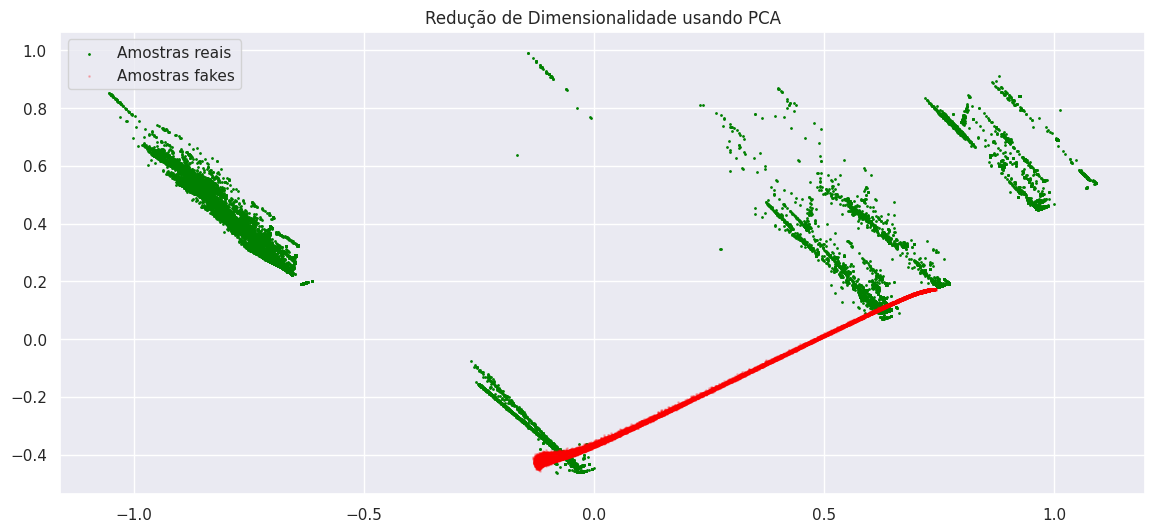

In [ ]:
plot_pca(norm_X_train_subset, norm_X_fake)

### Por que será que a GAN não conseguiu performar bem para gerar os dados?
<div align="center">

![thinking](https://i.pinimg.com/236x/a1/af/5e/a1af5eb72e73424b0afe12a777949464.jpg)
</div>



## Uma possível solução - WGAN com Gradient Penalty

A Wasserstein GAN é considerada como uma extensão da rede Generativa Adversarial introduzida por Ian Goodfellow. A WGAN foi introduzida por Martin Arjovsky em 2017 e promete melhorar tanto a estabilidade no treinamento do modelo quanto introduzir uma função de perda que seja capaz de se correlacionar com a qualidade dos eventos gerados.

Em vez de usar o conceito de "discriminador", a WGAN usa o conceito de "crítico", pois o mesmo vai fornecer como saída um número real qualquer, que não esteja delimitado em um intervalo que aponta o quanto as amostras geradas artificialmente são diferentes das reais, diferente do antigo discriminador, que fornecia saídas probabilistícas entre [0, 1]

**As principais diferenças introduzidas pela WGAN são**:

1. Usar uma nova função de perda derivada da distância de Wasserstein (WLoss).
2. Após cada atualização de gradiente na função crítica, fixar os pesos a uma pequena faixa fixa, [-c,c]. Isto permite aplicar a restrição de Lipschitz.
Alternativa proposta ao Discriminador — o Crítico.
3. Uso de uma função de ativação linear como a linear de saída da rede do Critic.
4. Número diferente de atualizações para o Gerador e para o crítico.

**Os principais benefícios da WGAN são**:
- Treinamento mais estável do que o da GAN tradicional
- Reduz os problemas de *mode collapse* da GAN tradicional
- Reduz o problema de *vanishing gradients* da GAN tradicional
- Menos sensível e impactada por hiperparâmetros e arquiteturas das redes do que a GAN tradicional


In [ ]:
# Modulo "crítico"
class Critic(nn.Module):
  def __init__(self, tab_data_dim, lrelu_slope = 0.1):
    super().__init__()

    self.disc = nn.Sequential(
      nn.Linear(tab_data_dim, 120), # Layer 1
      nn.LeakyReLU(lrelu_slope),
      nn.Linear(120, 80), # Layer 2
      nn.LeakyReLU(lrelu_slope),
      nn.Linear(80, 1),
      # Percebam que não tem a função de ativação sigmoide
    )

  def forward(self, x):
    return self.disc(x)

class WGANGP(nn.Module):
  def __init__(self, z_dim, tab_data_dim, lrelu_slope=0.1, device = None):
    super().__init__()
    if not device:
      self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    self.z_dim = z_dim
    self.tab_data_dim = tab_data_dim
    self.lrelu_slope = lrelu_slope

    self.critic = Critic(self.tab_data_dim, self.lrelu_slope).to(self.device)
    self.generator = Generator(self.z_dim, tab_data_dim, self.lrelu_slope).to(self.device)

    # Opcional: usado para testes
    self.fixed_noise = None
    self.step = 0

  def compile(self, lr):
    assert self.critic and self.generator, 'Critic and generator must be initialized before using compile method.'

    self.optim_critic = optim.Adam(self.critic.parameters(), lr=lr)
    self.optim_generator = optim.Adam(self.generator.parameters(), lr=lr)

  # Uma das diferenças da WGAN
  def gradient_penalty(self, real, fake):
    batch_size = real.shape[0]
    epsilon = torch.rand(real.shape).to(self.device)
    interpolated_data = real*epsilon + (1 - epsilon)*fake

    # Calcular escores da imagem interpolada usando o crítico
    interpolated_scores = self.critic(interpolated_data)

    # Calcular o gradiente dos escores da imagem interpolada
    gradient = torch.autograd.grad(
        inputs = interpolated_data,
        outputs = interpolated_scores,
        grad_outputs = torch.ones_like(interpolated_scores),
        create_graph = True,
        retain_graph = True
    )[0]

    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1)**2)
    return gradient_penalty

  def fit(self, X, batch_size, num_epochs, critic_iterations=5, lambda_gp = 0.05):
    assert self.optim_critic and self.optim_generator, 'Compile method must be called before using fit method.'

    # Opcional: usado apenas para testes
    if self.fixed_noise is None:
      self.fixed_noise = torch.randn((8, self.z_dim)).to(self.device)

    for epoch in range(num_epochs):
      print(f'Epoch#{epoch}')
      for batch in tqdm(range(0, len(X), batch_size)):
        real = X[batch:batch+batch_size]
        real = real.view(-1, self.tab_data_dim).to(self.device)
        curr_batch_size = real.shape[0]

        # Treinar o critico: maximizar a Earth's Mover Distance (ou minimizar o oposto da mesma)
        for _ in range(critic_iterations):
          noise = torch.randn(curr_batch_size, self.z_dim).to(self.device)
          fake = self.generator(noise)

          critic_real_output = self.critic(real).view(-1)
          critic_fake_output = self.critic(fake).view(-1)

          gp = self.gradient_penalty(real, fake)
          lossC = -(torch.mean(critic_real_output) - torch.mean(critic_fake_output)) + lambda_gp*gp
          self.critic.zero_grad()
          lossC.backward(retain_graph=True) # Para manter os gradientes para otimizar o generator
          self.optim_critic.step()

        # Treinar o gerador para minimzar log(1 - D(G(z))) <-> maximizar log(D(G(z)))
        output = self.critic(fake).view(-1)
        lossG = -torch.mean(output)
        self.generator.zero_grad()
        lossG.backward()
        self.optim_generator.step()

      print(
        f"Epoch [{epoch+1}/{num_epochs}] - Last Loss C: {lossC:.4f}, Last Loss G: {lossG:.4f}"
      )

In [ ]:
wgangp = WGANGP(z_dim=Z_DIM, tab_data_dim=TAB_DATA_DIM)
wgangp.compile(lr=LR)
print(f'device: {wgangp.device}')
wgangp.fit(X=torch.tensor(norm_X_train, dtype=torch.float), batch_size=BATCH_SIZE, num_epochs=2)

device: cpu
Epoch#0


  0%|          | 0/19652 [00:00<?, ?it/s]

Epoch [1/2] - Last Loss C: -0.2238, Last Loss G: 0.4806
Epoch#1


  0%|          | 0/19652 [00:00<?, ?it/s]

Epoch [2/2] - Last Loss C: -0.1186, Last Loss G: -0.5306


In [ ]:
# ---> Rode essa célula para baixar modelo pré-treinado <---

!wget 'https://drive.usercontent.google.com/download?id=14iRVOF-orDJKVjXH5d9_PbJKcz1m0mvb&export=download&authuser=0&confirm=t&uuid=2c68ccd7-19a9-4afa-91de-349ad4073192&at=APZUnTUsI1aMOXcIGpQAiQeCTMfs:1705153857727' -O 'pretrained_wgangp.pt'
wgangp = torch.load('pretrained_wgangp.pt', map_location=torch.device('cpu'))


--2024-02-29 23:53:33--  https://drive.usercontent.google.com/download?id=14iRVOF-orDJKVjXH5d9_PbJKcz1m0mvb&export=download&authuser=0&confirm=t&uuid=2c68ccd7-19a9-4afa-91de-349ad4073192&at=APZUnTUsI1aMOXcIGpQAiQeCTMfs:1705153857727
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.122.132, 2607:f8b0:4004:c09::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.122.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 401045 (392K) [application/octet-stream]
Saving to: ‘pretrained_wgangp.pt’

pretrained_wgangp.p 100%[===================>] 391.65K  --.-KB/s    in 0.03s   

2024-02-29 23:53:33 (12.1 MB/s) - ‘pretrained_wgangp.pt’ saved [401045/401045]



### Gerando dados artificialmente

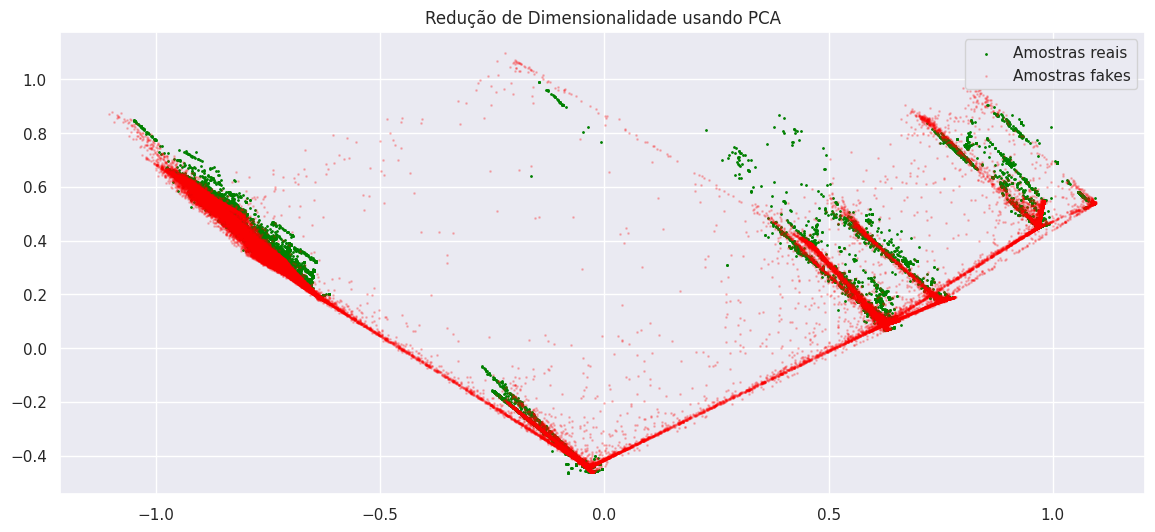

In [ ]:
QTD_INSTANCES = 100000

noises = torch.randn(QTD_INSTANCES, wgangp.z_dim).to(torch.device('cpu'))
norm_X_wgangp_fake = wgangp.generator(noises).cpu().detach().numpy()

random_train_indexes = np.random.choice(norm_X_train.shape[0], QTD_INSTANCES, replace=False)
norm_X_train_subset = norm_X_train[random_train_indexes,:]

plot_pca(norm_X_train_subset, norm_X_wgangp_fake)


# Definindo um threshold e avaliando resultados

In [ ]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [ ]:
def get_tpr_per_attack(y_labels, y_pred):
  aux_df = pd.DataFrame({'Label':y_labels,'prediction':y_pred})
  total_per_label = aux_df['Label'].value_counts().to_dict()
  correct_predictions_per_label = aux_df.query('Label != "BENIGN" and prediction == True').groupby('Label').size().to_dict()
  tpr_per_attack = {}
  for attack_label, total in total_per_label.items():
    if attack_label == 'BENIGN':
      continue
    tp = correct_predictions_per_label[attack_label] if attack_label in correct_predictions_per_label else 0
    tpr = tp/total
    tpr_per_attack[attack_label] = tpr
  return tpr_per_attack

In [ ]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

## Conjunto de validação - GAN Tradicional

In [ ]:
val_scores_gan = gan.discriminator(torch.tensor(norm_X_val, dtype=torch.float).to(gan.device))
val_scores_gan = val_scores_gan.cpu().detach().numpy()

anomaly_score_gan = 1 - val_scores_gan # Pois a saida do discriminador da GAN aponta a probabilidade de uma instância ser REAL (benigna). Podemos estimar a probabilidade da instância x ser maliciosa com 1 - D(x)

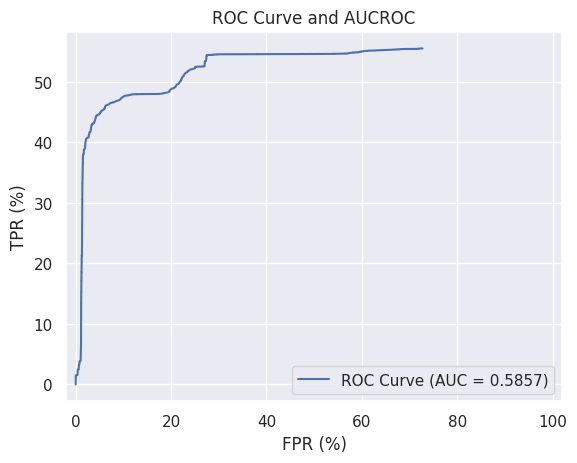

In [ ]:
plot_roc_curve(y_val, anomaly_score_gan)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, anomaly_score_gan)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').query('fpr < 0.4')

,fpr,tpr,thresholds,youden-index
9192,0.043931,0.444598,0.112495,0.400667
9190,0.043928,0.444591,0.112504,0.400664
9193,0.043941,0.444598,0.112491,0.400657
9183,0.043894,0.444544,0.112558,0.400651
9194,0.043948,0.444598,0.112490,0.400650
...,...,...,...,...
15,0.000177,0.002543,0.999999,0.002365
14,0.000174,0.002415,0.999999,0.002241
13,0.000170,0.002348,0.999999,0.002178
12,0.000075,0.002227,0.999999,0.002152


In [ ]:
GAN_BEST_VALIDATION_THRESHOLD = 0.736793

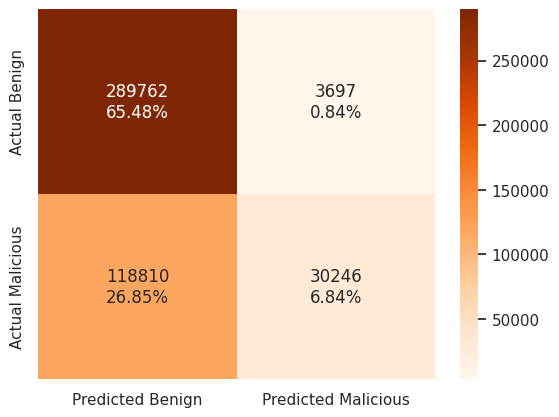

In [ ]:
plot_confusion_matrix(y_val, anomaly_score_gan > GAN_BEST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_val, val_scores_gan > GAN_BEST_VALIDATION_THRESHOLD)

{'acc': 0.21520400438403217,
 'tpr': 0.5977686238729069,
 'fpr': 0.9791112216698074,
 'precision': 0.23670005047419174,
 'f1-score': 0.3391184541548205}

In [ ]:
get_tpr_per_attack(classes_val, (val_scores_gan > GAN_BEST_VALIDATION_THRESHOLD)[:,0])

{'DoS Hulk': 0.15538217402803492,
 'DDoS': 0.815649689773691,
 'PortScan': 0.9999685405983578,
 'DoS GoldenEye': 0.8455555555555555,
 'FTP-Patator': 0.9995183044315993,
 'DoS slowloris': 0.9973474801061007,
 'DoS Slowhttptest': 0.9825136612021858,
 'SSH-Patator': 1.0,
 'Bot': 0.9956076134699854,
 'Brute Force': 1.0,
 'XSS': 1.0,
 'Infiltration': 1.0,
 'Sql Injection': 1.0,
 'Heartbleed': 0.75}

## Conjunto de validação - WGANGP

In [ ]:
val_scores_wgangp = wgangp.critic(torch.tensor(norm_X_val, dtype=torch.float).to(torch.device('cpu')))
val_scores_wgangp = val_scores_wgangp.cpu().detach().numpy()

anomaly_score_wgangp = -val_scores_wgangp


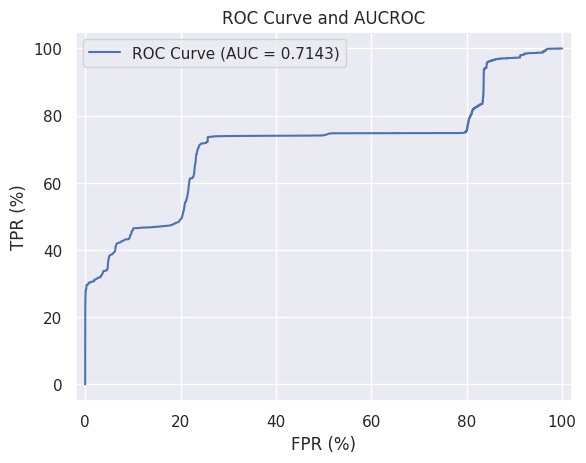

In [ ]:
plot_roc_curve(y_val, anomaly_score_wgangp)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, anomaly_score_wgangp)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').query('fpr < 0.15')

,fpr,tpr,thresholds,youden-index
21191,0.100750,0.464369,0.250958,0.363619
21193,0.100757,0.464376,0.250958,0.363619
21189,0.100747,0.464362,0.250960,0.363616
21195,0.100767,0.464383,0.250957,0.363615
21200,0.100788,0.464403,0.250954,0.363615
...,...,...,...,...
8,0.000014,0.000564,1.099585,0.000550
6,0.000010,0.000409,1.102866,0.000399
4,0.000007,0.000101,1.165971,0.000094
2,0.000003,0.000074,1.188408,0.000070


In [ ]:
WGANGP_BEST_VALIDATION_THRESHOLD = 0.250947

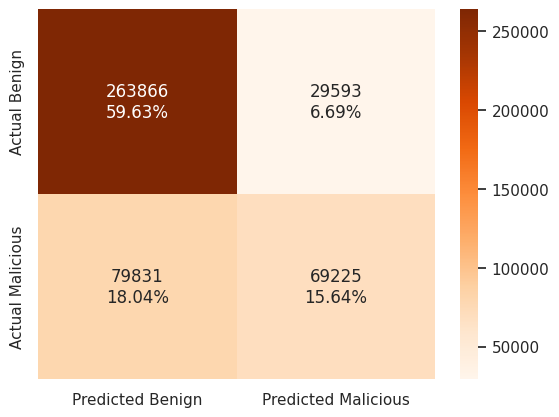

In [ ]:
plot_confusion_matrix(y_val, anomaly_score_wgangp > WGANGP_BEST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_val, val_scores_wgangp > WGANGP_BEST_VALIDATION_THRESHOLD)

{'acc': 0.6080675231348089,
 'tpr': 0.02746618720480893,
 'fpr': 0.09702888648840213,
 'precision': 0.12570621468926554,
 'f1-score': 0.04508214773377968}

In [ ]:
get_tpr_per_attack(classes_val, (val_scores_wgangp > WGANGP_BEST_VALIDATION_THRESHOLD)[:,0])

{'DoS Hulk': 0.0017852419994710395,
 'DDoS': 2.231843949471053e-05,
 'PortScan': 0.024412495674332273,
 'DoS GoldenEye': 0.09638888888888889,
 'FTP-Patator': 0.0004816955684007707,
 'DoS slowloris': 0.5421750663129974,
 'DoS Slowhttptest': 0.6568306010928961,
 'SSH-Patator': 0.0008873114463176575,
 'Bot': 0.007320644216691069,
 'Brute Force': 0.8093385214007782,
 'XSS': 0.9385964912280702,
 'Infiltration': 0.07692307692307693,
 'Sql Injection': 0.0,
 'Heartbleed': 0.0}

## Conjunto de teste - GAN Tradicional

In [ ]:
test_scores_gan = gan.discriminator(torch.tensor(norm_X_test, dtype=torch.float).to(gan.device))
test_scores_gan = test_scores_gan.cpu().detach().numpy()

test_anomaly_scores_gan = 1 - test_scores_gan

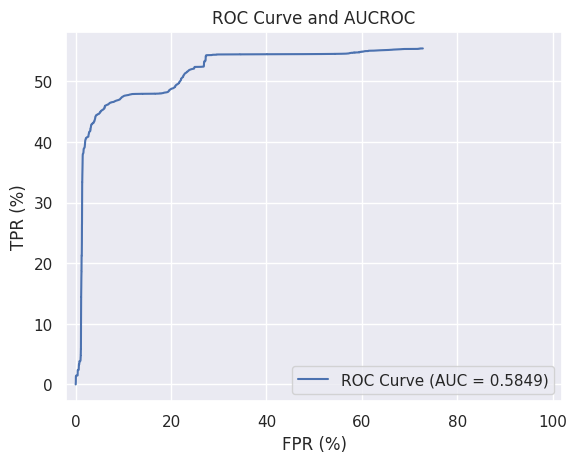

In [ ]:
plot_roc_curve(y_test, test_anomaly_scores_gan)

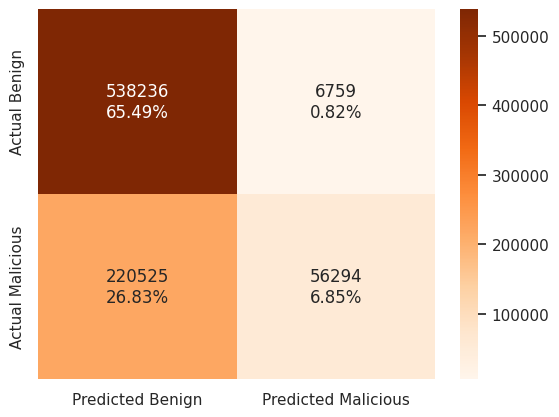

In [ ]:
plot_confusion_matrix(y_test, test_anomaly_scores_gan > GAN_BEST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_test, test_anomaly_scores_gan > GAN_BEST_VALIDATION_THRESHOLD)

{'acc': 0.7234362033258134,
 'tpr': 0.20336031847524916,
 'fpr': 0.012401948641730658,
 'precision': 0.892804466084088,
 'f1-score': 0.33126588833443177}

In [ ]:
get_tpr_per_attack(classes_test, (test_anomaly_scores_gan > GAN_BEST_VALIDATION_THRESHOLD)[:,0])

{'DoS Hulk': 0.3997329773030708,
 'DDoS': 0.13238793414253094,
 'PortScan': 0.0,
 'DoS GoldenEye': 0.05055339515405324,
 'FTP-Patator': 0.00025926886180969663,
 'DoS slowloris': 0.0,
 'DoS Slowhttptest': 0.007651559741024131,
 'SSH-Patator': 0.0,
 'Bot': 0.0015748031496062992,
 'Brute Force': 0.0,
 'XSS': 0.0,
 'Infiltration': 0.0,
 'Sql Injection': 0.0,
 'Heartbleed': 0.14285714285714285}

## Conjunto de teste - WGANGP

In [ ]:
test_scores_wgangp = wgangp.critic(torch.tensor(norm_X_test, dtype=torch.float).to(torch.device('cpu')))
test_scores_wgangp = test_scores_wgangp.cpu().detach().numpy()

test_anomaly_scores_wgapgp = -test_scores_wgangp

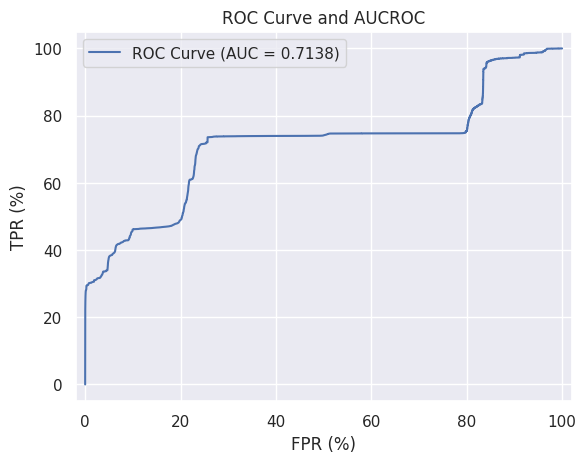

In [ ]:
plot_roc_curve(y_test, test_anomaly_scores_wgapgp)

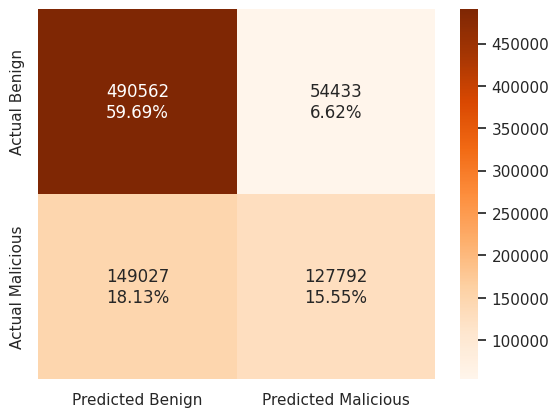

In [ ]:
plot_confusion_matrix(y_test, test_anomaly_scores_wgapgp > WGANGP_BEST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_test, test_anomaly_scores_wgapgp > WGANGP_BEST_VALIDATION_THRESHOLD)

{'acc': 0.752425731369872,
 'tpr': 0.46164461254465916,
 'fpr': 0.09987798053193149,
 'precision': 0.7012868706269721,
 'f1-score': 0.5567745139899443}

In [ ]:
get_tpr_per_attack(classes_test, (test_anomaly_scores_wgapgp > WGANGP_BEST_VALIDATION_THRESHOLD)[:,0])

{'DoS Hulk': 0.4294882064975523,
 'DDoS': 0.8836437928133638,
 'PortScan': 0.0015584767583683426,
 'DoS GoldenEye': 0.5047861202512713,
 'FTP-Patator': 0.3248638838475499,
 'DoS slowloris': 0.056,
 'DoS Slowhttptest': 0.2857563272513243,
 'SSH-Patator': 0.008126195028680689,
 'Bot': 0.07401574803149606,
 'Brute Force': 0.0020920502092050207,
 'XSS': 0.007075471698113208,
 'Infiltration': 0.30434782608695654,
 'Sql Injection': 0.0,
 'Heartbleed': 0.14285714285714285}

# Perguntas

## 1. Explique como é esperado, na teoria, que modelos basedos em GANs realizem detecção de anomalias.

As GANs se tornaram muito conhecido pela sua aplicação em imagens. Porém, elas tem o poder de detectar anomalias em qualquer tipo de dados. Sendo assim, podemos usar dados benignos de rede para treinar uma GAN, de forma que o gerador possa gerar dados falsos que sejam muito semelhante aos legítimos e o descriminador irá ser capaz de destinguir dados légitimos de falsos com muito mais precisão. Com isso, após o treinamento, o discriminador recebe amostras de dados e retorna um valor chamado ***discrimination loss*** representando o quão provável esse dado representa uma anômalia.

## 2. Através da redução de dimensionalidade, é possível observar que os dados gerados pela GAN tradicional possuem uma diferença para os dados gerados pela WGAN. O que você observou como diferente nos dados gerados pela WGAN? Por que isso aconteceu?

Observo que a WGAN foi capaz de detectar muito mais dados malignos que a GAN tradicional. Isso porque a WGAN faz uso de penalidade de gradiente, permitindo uma distribuição mais suave dos dados e próxima da realidade.

## 3. Explique possíveis razões para que a WGAN deu melhores resultados para detecção de anomalias em comparação com a GAN tradicional.

Umas das possíveis razões para isso é o fato de que as WGANs usam a distância de Wasserstein como métrica de custo, garantindo um treino mais estável. Além disso, a inclusão de penalidade de gradiente proporciona uma distribuição mais suave dos dados e ajuda a evitar modos colapsados. A convergências em modelos WGAN tendem a ser mais rápidos que em GANs tradicionais. Por fim, as WGANs tendem a evitar o problemas de ***vanish gradient***, permitindo uma aprendizagem mais eficaz.

# Atividade de código

## Refaça o código da WGAN com Gradient Penalty considerando que as redes do discriminador e gerador tenham apenas UMA camada interna antes da camada de saída e avalie os resultados

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Módulo gerador
class Generator(nn.Module):
    def __init__(self, z_dim, tab_data_dim, lrelu_slope=0.1):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            nn.Linear(z_dim, 120),   # Camada única antes da saída
            nn.LeakyReLU(lrelu_slope),
            nn.Linear(120, tab_data_dim),
            nn.Sigmoid()             # Camada de saída com ativação Sigmoid
        )

    def forward(self, x):
        return self.gen(x)

# Módulo crítico
class Critic(nn.Module):
    def __init__(self, tab_data_dim, lrelu_slope=0.1):
        super(Critic, self).__init__()

        self.disc = nn.Sequential(
            nn.Linear(tab_data_dim, 100),   # Camada única antes da saída
            nn.LeakyReLU(lrelu_slope),
            nn.Linear(100, 1)                # Camada de saída
        )

    def forward(self, x):
        return self.disc(x)

# WGAN-GP
class WGANGP(nn.Module):
    def __init__(self, z_dim, tab_data_dim, lrelu_slope=0.1, device=None):
        super(WGANGP, self).__init__()

        if not device:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.z_dim = z_dim
        self.tab_data_dim = tab_data_dim
        self.lrelu_slope = lrelu_slope

        self.critic = Critic(self.tab_data_dim, self.lrelu_slope).to(self.device)
        self.generator = Generator(self.z_dim, tab_data_dim, self.lrelu_slope).to(self.device)

        # Opcional: usado para testes
        self.fixed_noise = None
        self.step = 0

    def compile(self, lr):
        assert self.critic and self.generator, 'Critic and generator must be initialized before using compile method.'

        self.optim_critic = optim.Adam(self.critic.parameters(), lr=lr)
        self.optim_generator = optim.Adam(self.generator.parameters(), lr=lr)

    # Uma das diferenças da WGAN
    def gradient_penalty(self, real, fake):
        batch_size = real.shape[0]
        epsilon = torch.rand(real.shape).to(self.device)
        interpolated_data = real * epsilon + (1 - epsilon) * fake

        # Calcular escores da imagem interpolada usando o crítico
        interpolated_scores = self.critic(interpolated_data)

        # Calcular o gradiente dos escores da imagem interpolada
        gradient = torch.autograd.grad(
            inputs=interpolated_data,
            outputs=interpolated_scores,
            grad_outputs=torch.ones_like(interpolated_scores),
            create_graph=True,
            retain_graph=True
        )[0]

        gradient = gradient.view(len(gradient), -1)
        gradient_norm = gradient.norm(2, dim=1)
        gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
        return gradient_penalty

    def fit(self, X, batch_size, num_epochs, critic_iterations=5, lambda_gp=0.05):
        assert self.optim_critic and self.optim_generator, 'Compile method must be called before using fit method.'

        # Opcional: usado apenas para testes
        if self.fixed_noise is None:
            self.fixed_noise = torch.randn((8, self.z_dim)).to(self.device)

        for epoch in range(num_epochs):
            print(f'Epoch#{epoch}')
            for batch in tqdm(range(0, len(X), batch_size)):
                real = X[batch:batch + batch_size]
                real = real.view(-1, self.tab_data_dim).to(self.device)
                curr_batch_size = real.shape[0]

                # Treinar o critico: maximizar a Earth's Mover Distance (ou minimizar o oposto da mesma)
                for _ in range(critic_iterations):
                    noise = torch.randn(curr_batch_size, self.z_dim).to(self.device)
                    fake = self.generator(noise)

                    critic_real_output = self.critic(real).view(-1)
                    critic_fake_output = self.critic(fake).view(-1)

                    gp = self.gradient_penalty(real, fake)
                    lossC = -(torch.mean(critic_real_output) - torch.mean(critic_fake_output)) + lambda_gp * gp
                    self.critic.zero_grad()
                    lossC.backward(retain_graph=True)  # Para manter os gradientes para otimizar o generator
                    self.optim_critic.step()

                # Treinar o gerador para minimizar log(1 - D(G(z))) <-> maximizar log(D(G(z)))
                output = self.critic(fake).view(-1)
                lossG = -torch.mean(output)
                self.generator.zero_grad()
                lossG.backward()
                self.optim_generator.step()

            print(
                f"Epoch [{epoch + 1}/{num_epochs}] - Last Loss C: {lossC:.4f}, Last Loss G: {lossG:.4f}"
            )

In [ ]:
wgangp2 = WGANGP(z_dim=Z_DIM, tab_data_dim=TAB_DATA_DIM)
wgangp2.compile(lr=LR)
print(f'device: {wgangp2.device}')
wgangp2.fit(X=torch.tensor(norm_X_train, dtype=torch.float), batch_size=BATCH_SIZE, num_epochs=2)

device: cpu
Epoch#0


100%|██████████| 19652/19652 [05:20<00:00, 61.38it/s]


Epoch [1/2] - Last Loss C: 0.0147, Last Loss G: -0.6871
Epoch#1


100%|██████████| 19652/19652 [05:13<00:00, 62.66it/s]

Epoch [2/2] - Last Loss C: -0.0005, Last Loss G: -0.7311


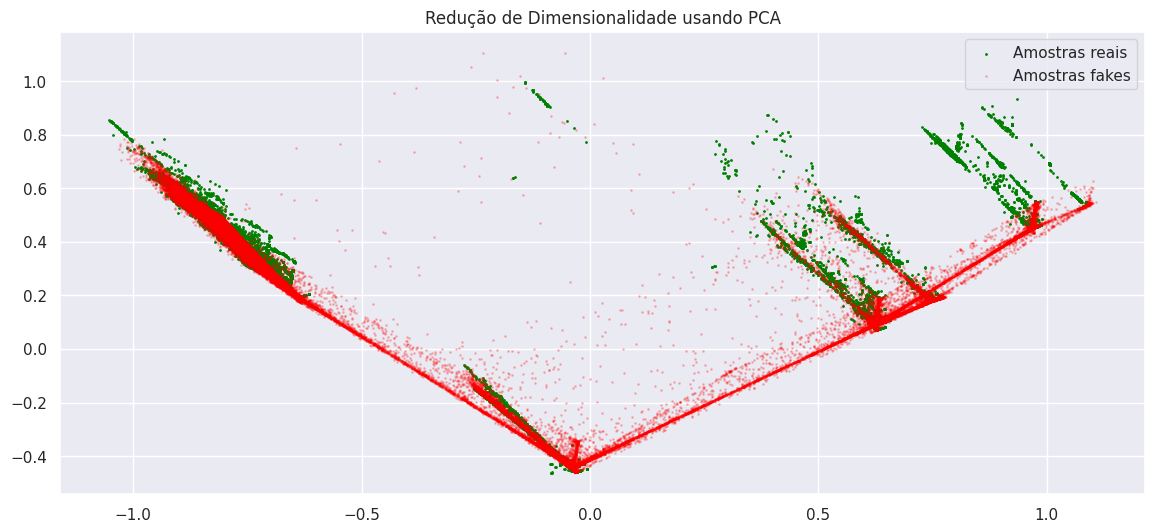

In [ ]:
QTD_INSTANCES = 100000

noises = torch.randn(QTD_INSTANCES, wgangp2.z_dim).to(torch.device('cpu'))
norm_X_wgangp2_fake = wgangp2.generator(noises).cpu().detach().numpy()

random_train_indexes = np.random.choice(norm_X_train.shape[0], QTD_INSTANCES, replace=False)
norm_X_train_subset = norm_X_train[random_train_indexes,:]

plot_pca(norm_X_train_subset, norm_X_wgangp2_fake)


##Observações##

Percebe-se que a WGAN de uma camada paresenta uma distribiição de dados benignos e malignos muito semelhante a da WGAN de duas camadas.

## Conjunto de validação - WGANGP

In [ ]:
val_scores_wgangp2 = wgangp2.critic(torch.tensor(norm_X_val, dtype=torch.float).to(torch.device('cpu')))
val_scores_wgangp2 = val_scores_wgangp2.cpu().detach().numpy()

anomaly_score_wgangp2 = -val_scores_wgangp2

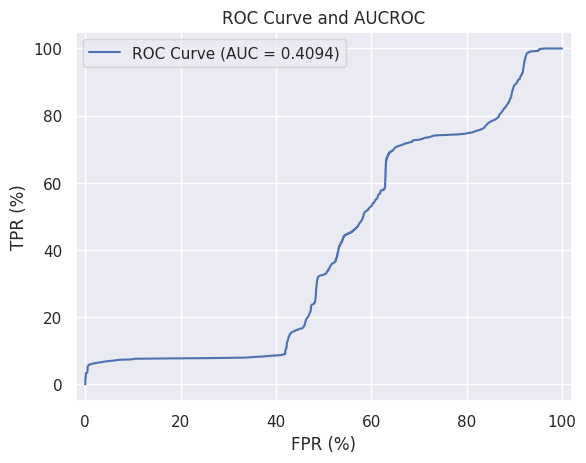

In [ ]:
plot_roc_curve(y_val, anomaly_score_wgangp2)

##Observações##

Avaliando a curva ROC, percebe-se uma piora cconsiderável em relação a curva ROC da WGAN de duas camadas. Acredito que isso esteja relacionada ao fato de que a redução no número de camadas no gerador e no crítico, fez com que o modelo não fosse capaz de realizar detectar com eficiência dados benignos de malignos.

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, anomaly_score_wgangp2)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').query('fpr < 0.15')

,fpr,tpr,thresholds,youden-index
2481,0.007943,0.059099,-0.625938,0.051155
2473,0.007906,0.059058,-0.625628,0.051153
2477,0.007930,0.059078,-0.625907,0.051149
2479,0.007936,0.059085,-0.625926,0.051149
2475,0.007919,0.059065,-0.625833,0.051146
...,...,...,...,...
16366,0.149912,0.077085,-0.661593,-0.072827
16368,0.149936,0.077092,-0.661596,-0.072844
16369,0.149943,0.077092,-0.661597,-0.072851
16370,0.149963,0.077092,-0.661601,-0.072871


In [ ]:
WGANGP_BEST_VALIDATION_THRESHOLD = -0.661601

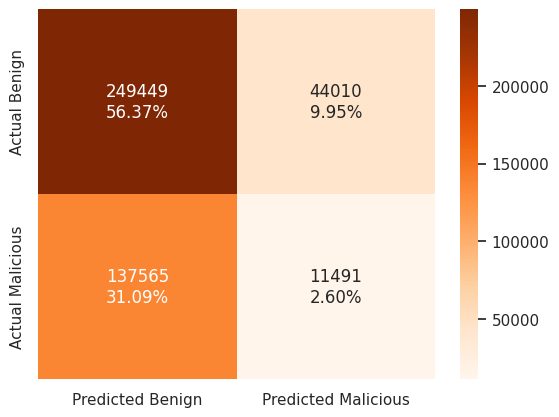

In [ ]:
plot_confusion_matrix(y_val, anomaly_score_wgangp2 > WGANGP_BEST_VALIDATION_THRESHOLD)

##Observações##

Avaliando a matriz de confusão, percebe-se que o que foi dito a respeito da curva ROC acima é fato. O modelo tem uma baixa de capacidade de detectar dados malignos. Além disso, ele considera muitos dados malignos como benignos. Sendo assim, o modelo tende a acreditar que a maioria esmagadora dos dados são malignos, demonstrando extrema imprecisão e identificar anomalias.

In [ ]:
get_overall_metrics(y_val, val_scores_wgangp2 > WGANGP_BEST_VALIDATION_THRESHOLD)

{'acc': 0.3368382992666915,
 'tpr': 1.0,
 'fpr': 1.0,
 'precision': 0.3368382992666915,
 'f1-score': 0.5039327485627253}

In [ ]:
get_tpr_per_attack(classes_val, (val_scores_wgangp2 > WGANGP_BEST_VALIDATION_THRESHOLD)[:,0])

{'DoS Hulk': 1.0,
 'DDoS': 1.0,
 'PortScan': 1.0,
 'DoS GoldenEye': 1.0,
 'FTP-Patator': 1.0,
 'DoS slowloris': 1.0,
 'DoS Slowhttptest': 1.0,
 'SSH-Patator': 1.0,
 'Bot': 1.0,
 'Brute Force': 1.0,
 'XSS': 1.0,
 'Infiltration': 1.0,
 'Sql Injection': 1.0,
 'Heartbleed': 1.0}

##Observação##

Observando os dados acima, percebe-se que ela detectar todos os dados malignos com 100% de aproveitamento. Acredito que estamos diante de um overfitting. Além disso, com excessão da taxa de falso/verdadeiro positivo, percebemos que outras métricas são péssimas.

## Conjunto de teste - WGANGP

In [ ]:
test_scores_wgangp2 = wgangp2.critic(torch.tensor(norm_X_test, dtype=torch.float).to(torch.device('cpu')))
test_scores_wgangp2 = test_scores_wgangp2.cpu().detach().numpy()

test_anomaly_scores_wgapgp2 = -test_scores_wgangp2

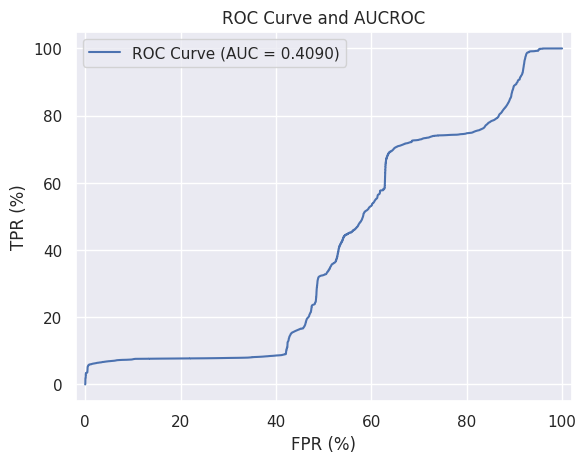

In [ ]:
plot_roc_curve(y_test, test_anomaly_scores_wgapgp2)

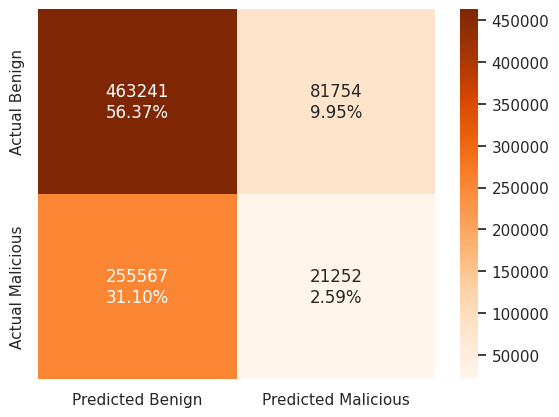

In [ ]:
plot_confusion_matrix(y_test, test_anomaly_scores_wgapgp2 > WGANGP_BEST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_test, test_anomaly_scores_wgapgp2 > WGANGP_BEST_VALIDATION_THRESHOLD)

{'acc': 0.5895409423543527,
 'tpr': 0.07677218688023582,
 'fpr': 0.15000871567629062,
 'precision': 0.20631807855853057,
 'f1-score': 0.11190416639241758}

In [ ]:
get_tpr_per_attack(classes_test, (test_anomaly_scores_wgapgp2 > WGANGP_BEST_VALIDATION_THRESHOLD)[:,0])

{'DoS Hulk': 0.015549621717846017,
 'DDoS': 0.21682490085326284,
 'PortScan': 0.0014060170754844829,
 'DoS GoldenEye': 0.1073885731379001,
 'FTP-Patator': 0.0,
 'DoS slowloris': 0.18914285714285714,
 'DoS Slowhttptest': 0.0,
 'SSH-Patator': 0.0,
 'Bot': 0.0,
 'Brute Force': 0.0,
 'XSS': 0.0,
 'Infiltration': 0.0,
 'Sql Injection': 0.0,
 'Heartbleed': 0.0}

##Observações##

Observando os resultados no conjunto de teste, percebemos que a curva ROC continua tão ruim quanto antes. Além disso, a matriz de confusão ainda indica que o modelo tem uma forte inclinação a acreditar que a um dado é benigno. Porém perceba que a taxa de falso/verdadeiro positivo, f1-score, acuracia e precisão estão muito ruins. Além disso, o modelo se mostrou péssimo na detecção de anomalias, apresentando 0% na maioria deles. Sendo assim, confirmo as suspeitas de um overfitting.